In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets
from torchvision.models import resnet50
from torch.utils.data import random_split, DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import torchvision.transforms.functional as F
from torchvision.models.vision_transformer import vit_b_16
from PIL import Image
import cv2
import random
import os

c:\Users\danym\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class EdgeEnhancementTransform:
    def __call__(self, img):
        # img = np.array(F.to_grayscale(img))  # Convert to grayscale
        img = np.array(img)
        img = cv2.GaussianBlur(img, (3, 3), 0)  # Reduce noise
        edges = cv2.Laplacian(img, cv2.CV_64F)  # Edge detection
        edges = np.clip((edges - edges.min()) / (edges.max() - edges.min()) * 255, 0, 255).astype(np.uint8)
        return Image.fromarray(edges)
        # return F.to_tensor()

# image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomApply([EdgeEnhancementTransform()], p=0.5),  # Apply edge emphasis randomly
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Adjusted normalization
])
# load the datasets
dataset_path = './dataset'
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = full_dataset.classes
print(f'Classes: {class_names}')

Classes: ['battery', 'cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'syringe', 'trash']


In [3]:
# split dataset into train and test
# train_size = int(0.8 * len(full_dataset))
# test_size = len(full_dataset) - train_size
# train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

labels = [label for _, label in full_dataset]
labels = np.array(labels)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in splitter.split(np.zeros(len(labels)), labels):
    train_dataset = Subset(full_dataset, train_idx)
    test_dataset = Subset(full_dataset, test_idx)

print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of testing samples: {len(test_dataset)}')

# data loaders
batch_size = 32
num_workers = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

Number of training samples: 5530
Number of testing samples: 1383


In [4]:
# Load the ViT model
model = vit_b_16(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier head
num_classes = len(class_names)
model.heads.head = nn.Linear(model.hidden_dim, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.heads.head.parameters(), lr=0.001)

c:\Users\danym\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\danym\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda


In [5]:
# Training loop
epochs = 10
print("Training started...")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

print("Training complete.")

Training started...


c:\Users\danym\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 1/10, Loss: 0.9993
Epoch 2/10, Loss: 0.6174
Epoch 3/10, Loss: 0.5362
Epoch 4/10, Loss: 0.4919
Epoch 5/10, Loss: 0.4504
Epoch 6/10, Loss: 0.4428
Epoch 7/10, Loss: 0.4211
Epoch 8/10, Loss: 0.4098
Epoch 9/10, Loss: 0.3943
Epoch 10/10, Loss: 0.3775
Training complete.


In [6]:
# Validation
model.eval()
correct = 0
total = 0
true_labels = []
predicted_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f'Testing Accuracy: {accuracy:.2f}%')

# Calculate F1-Score
fscore = f1_score(true_labels, predicted_labels, average='macro')
print(f'F1-Score: {fscore:.4f}')

# Save model
torch.save(model.state_dict(), 'vit_model2.pth')
print("Model saved.")

Testing Accuracy: 83.37%
F1-Score: 0.8334
Model saved.


              precision    recall  f1-score   support

     battery       0.94      0.93      0.94        71
   cardboard       0.87      0.83      0.85       108
     compost       0.95      0.98      0.97       343
       glass       0.74      0.79      0.77       174
       metal       0.75      0.85      0.80       194
       paper       0.78      0.76      0.77       159
     plastic       0.83      0.67      0.74       241
     syringe       1.00      1.00      1.00        29
       trash       0.64      0.70      0.67        64

    accuracy                           0.83      1383
   macro avg       0.83      0.84      0.83      1383
weighted avg       0.84      0.83      0.83      1383



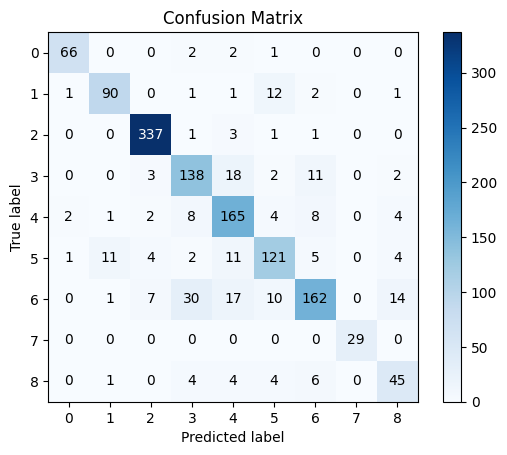

In [7]:
import scikitplot as skplt
from sklearn.metrics import classification_report

skplt.metrics.plot_confusion_matrix(true_labels, predicted_labels)
print(classification_report(true_labels, predicted_labels, target_names=['battery', 'cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'syringe', 'trash']))